<a href="https://colab.research.google.com/github/panupong-kha/ML/blob/main/Logistic_Regression/stock_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## แนะนำการวิเคราะห์หุ้นด้วย yahoo finance
- https://www.ultimatepython.co/post/python-yahoo-finance

In [ ]:
!pip install requests
!pip install lxml
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

## ให้นักศึกษาทำตาม link (ด้านล่าง) จนได้ผลลัพธ์ของภาพกราฟตามที่แสดงใน link

## https://blog.quantinsti.com/machine-learning-logistic-regression-python/

## a. โดย น.ศ. สามารถเลือกหุ้น (ทั่วโลก) ได้ตามใจชอบมา 1 หุ้น และจะใช้ data ย้อนหลังกี่วันก็ได้ แต่ time frame (window) ต้องเป็น 1 ชั่วโมงเหมือนกันทุกคน (ตามที่กำหนดไว้ใน starter kit link ==> แนะนำการวิเคราะห์หุ้นด้วย yahoo finance https://www.ultimatepython.co/post/python-yahoo-finance) แล้วแสดงผลลัพธ์ของกราฟ

- หุ้น Berkshire Hathaway Inc. ของ Warrent buffett ตัวย่อ BRK-B ตลาดหุ้น NYSE - NYSE Delayed Price. Currency in USD

## Step 1: Import Data

In [ ]:
BH = yf.Ticker('BRK-B')

In [ ]:
##ดึงข้อมูลได้แค่ 730 วัน กรณีดึงข้อมูลเป็นรายชั่วโมง

interval = '1h'

start = '2023-1-1'
end = '2023-12-31'

BH_price_df = BH.history(interval='1h',start=start,end=end)

In [ ]:
BH_price_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-01-03 09:30:00-05:00,309.899994,312.385010,308.899994,310.279999,852803,0.0,0.0
2023-01-03 10:30:00-05:00,310.359985,311.219910,308.570007,309.111603,309200,0.0,0.0
2023-01-03 11:30:00-05:00,309.170013,309.170013,307.920898,308.220001,253184,0.0,0.0
2023-01-03 12:30:00-05:00,308.200012,309.154999,307.490997,308.010010,230807,0.0,0.0
2023-01-03 13:30:00-05:00,307.989990,308.700012,307.380005,308.195007,208427,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-29 11:30:00-05:00,356.700012,356.989990,355.510010,355.670013,212870,0.0,0.0
2023-12-29 12:30:00-05:00,355.713989,356.059906,355.309998,355.489990,261654,0.0,0.0
2023-12-29 13:30:00-05:00,355.463501,356.079987,355.429993,355.820007,299533,0.0,0.0


In [ ]:
df = BH_price_df.copy()

In [ ]:
df = df.iloc[:, :4]
df.head()

,Open,High,Low,Close
Datetime,,,,
2023-01-03 09:30:00-05:00,309.899994,312.385010,308.899994,310.279999
2023-01-03 10:30:00-05:00,310.359985,311.219910,308.570007,309.111603
2023-01-03 11:30:00-05:00,309.170013,309.170013,307.920898,308.220001
2023-01-03 12:30:00-05:00,308.200012,309.154999,307.490997,308.010010
2023-01-03 13:30:00-05:00,307.989990,308.700012,307.380005,308.195007


## Step 2: Define Predictor/Independent Variables
- We will use 10-days moving average, correlation, relative strength index (RSI), the difference between the open price of yesterday and today, the difference between the close price of yesterday and the open price of today. Also, open, high, low, and close prices will be used as indicators to make the prediction.

## วิธีแก้ไขกรณี ติดตั้ง Ta-lib ไม่ได้ ใน Jupyter notebook บน macbook and windows
- https://blog.quantinsti.com/install-ta-lib-python/#install-ta-lib-on-macos
- https://blog.quantinsti.com/install-ta-lib-python/

## กรณีรันใน google colab

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
import talib as ta

In [ ]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X_df = df.iloc[:,:9]
X = X_df.copy()
X

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open
Datetime,,,,,,,,,
2023-01-10 10:30:00-05:00,314.000000,315.959991,313.339996,315.114990,317.266364,-0.094820,49.867408,-0.095001,-1.000000
2023-01-10 11:30:00-05:00,315.429993,316.200012,314.651398,315.920013,316.994363,0.149273,53.537603,0.315002,1.429993
2023-01-10 12:30:00-05:00,315.924988,316.786987,315.649994,316.056702,316.805032,0.317517,54.170589,0.004974,0.494995
2023-01-10 13:30:00-05:00,316.054108,316.799988,315.899994,316.149994,316.412341,0.417340,54.639234,-0.002594,0.129120
2023-01-10 14:30:00-05:00,316.075897,316.390015,314.910004,315.581696,315.968512,0.333331,51.102286,-0.074097,0.021790
...,...,...,...,...,...,...,...,...,...
2023-12-29 11:30:00-05:00,356.700012,356.989990,355.510010,355.670013,357.542001,-0.365859,33.787111,-0.029999,-1.159973
2023-12-29 12:30:00-05:00,355.713989,356.059906,355.309998,355.489990,357.341000,-0.389754,32.483064,0.043976,-0.986023
2023-12-29 13:30:00-05:00,355.463501,356.079987,355.429993,355.820007,357.165002,-0.316165,37.404070,-0.026489,-0.250488


## help resolve the convergence warnings, need to scale the data using StandardScaler

In [ ]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Assuming X is your feature matrix

## Step 3: Define Target/Dependent Variable
- The dependent variable is the same as discussed in the above example. If tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).

In [ ]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

In [ ]:
df['Close'] ##ต้องการดูราคาปิดของแต่ละชั่วโมงในแต่ละวัน

Datetime
2023-01-10 10:30:00-05:00    315.114990
2023-01-10 11:30:00-05:00    315.920013
2023-01-10 12:30:00-05:00    316.056702
2023-01-10 13:30:00-05:00    316.149994
2023-01-10 14:30:00-05:00    315.581696
                                ...    
2023-12-29 11:30:00-05:00    355.670013
2023-12-29 12:30:00-05:00    355.489990
2023-12-29 13:30:00-05:00    355.820007
2023-12-29 14:30:00-05:00    357.095001
2023-12-29 15:30:00-05:00    356.929993
Name: Close, Length: 1706, dtype: float64

In [ ]:
df['Close'].shift(-1) ##ต้องการดูราคาปิดของชั่วโมงหลังจากช่วงเวลาที่สนใจ

Datetime
2023-01-10 10:30:00-05:00    315.920013
2023-01-10 11:30:00-05:00    316.056702
2023-01-10 12:30:00-05:00    316.149994
2023-01-10 13:30:00-05:00    315.581696
2023-01-10 14:30:00-05:00    316.459991
                                ...    
2023-12-29 11:30:00-05:00    355.489990
2023-12-29 12:30:00-05:00    355.820007
2023-12-29 13:30:00-05:00    357.095001
2023-12-29 14:30:00-05:00    356.929993
2023-12-29 15:30:00-05:00           NaN
Name: Close, Length: 1706, dtype: float64

In [ ]:
df['Close'].shift(1) ##ต้องการดูราคาปิดของชั่วโมงก่อนหน้า

Datetime
2023-01-10 10:30:00-05:00           NaN
2023-01-10 11:30:00-05:00    315.114990
2023-01-10 12:30:00-05:00    315.920013
2023-01-10 13:30:00-05:00    316.056702
2023-01-10 14:30:00-05:00    316.149994
                                ...    
2023-12-29 11:30:00-05:00    356.730011
2023-12-29 12:30:00-05:00    355.670013
2023-12-29 13:30:00-05:00    355.489990
2023-12-29 14:30:00-05:00    355.820007
2023-12-29 15:30:00-05:00    357.095001
Name: Close, Length: 1706, dtype: float64

## Step 4: Split The Dataset
- We will split the dataset into a training dataset and test dataset. We will use 70% of our data to train and the rest 30% to test. To do this, we will create a split variable which will divide the data frame in a 70-30 ratio. ‘Xtrain’ and ‘Ytrain’ are train dataset. ‘Xtest’ and ‘Ytest’ are the test dataset.

In [ ]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

## Step 5: Instantiate The Logistic Regression in Python
- We will instantiate the logistic regression in Python using ‘LogisticRegression’ function and fit the model on the training dataset using ‘fit’ function.

In [ ]:
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [ ]:
model = LogisticRegression(max_iter=1000)
model = model.fit (X_train,y_train)

## Step 6: Examine The Coefficients

In [ ]:
pd.DataFrame(zip(X_df.columns, np.transpose(model.coef_)))

,0,1
0,Open,[0.15105811870827313]
1,High,[-0.6156343198474874]
2,Low,[0.45862763630197284]
3,Close,[0.21504854193250797]
4,S_10,[-0.21873436849619574]
5,Corr,[-0.05523373315129345]
6,RSI,[0.011419371778690294]
7,Open-Close,[-0.039250175183735754]
8,Open-Open,[-0.10526737591992254]


## Step 7: Calculate Class Probabilities
- We will calculate the probabilities of the class for the test dataset using ‘predict_proba’ function.

In [ ]:
# Specify the date for prediction
prediction_date = '2024-12-31'
probability = model.predict_proba(X_test)
probability

array([[0.47071806, 0.52928194],
       [0.4735236 , 0.5264764 ],
       [0.43774078, 0.56225922],
       ...,
       [0.45556371, 0.54443629],
       [0.47206388, 0.52793612],
       [0.4925287 , 0.5074713 ]])

## Step 8: Predict Class Labels
- Next, we will predict the class labels using predict function for the test dataset.
- In the output above, the signal shows 1, which is a buy signal
- -1 is a sell signal

In [ ]:
predicted = model.predict(X_test)
predicted

array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

## Step 9: Evaluate The Model
## 9.1 Confusion Matrix
- The Confusion matrix is used to describe the performance of the classification model on a set of test dataset for which the true values are known. We will calculate the confusion matrix using ‘confusion_matrix’ function.

In [ ]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 54 186]
 [ 60 212]]


## 9.2 Classification Report
- This is another method to examine the performance of the classification model.

In [ ]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.47      0.23      0.31       240
           1       0.53      0.78      0.63       272

    accuracy                           0.52       512
   macro avg       0.50      0.50      0.47       512
weighted avg       0.51      0.52      0.48       512



- The f1-score tells you the accuracy of the classifier in classifying the data points in that particular class compared to all other class. It is calculated by taking the harmonic mean of precision and recall. The support is the number of samples of the true response that lies in that class.
- The accuracy of the model is at 0.52 or 52%.

## 9.3 Model Accuracy

- We will calculate the model accuracy on the test dataset using ‘score’ function.

In [ ]:
print(model.score(X_test,y_test))

0.51953125


## 9.4 Cross-Validation

- We will cross-check the accuracy of the model using 10-fold cross-validation. For this, we will use ‘crossvalscore’ function which we have imported from ‘sklearn.cross_validation’ library.

In [ ]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.53216374 0.51461988 0.54385965 0.56725146 0.50292398 0.52631579
 0.52941176 0.52941176 0.5        0.51764706]
0.526360509115927


- The accuracy is still 52.64% which means the model is working fine.

## Step 10: Create Trading Strategy Using The Model

- We will predict the signal to buy (1) or sell (-1) and calculate the cumulative Berkshire_Hathaway returns for the test dataset. Next, we will calculate the cumulative strategy return based on the signal predicted by the model in the test dataset. We will also plot the cumulative returns.

In [ ]:
pip install matplotlib

In [ ]:
# Plotting graphs
import matplotlib.pyplot as plt

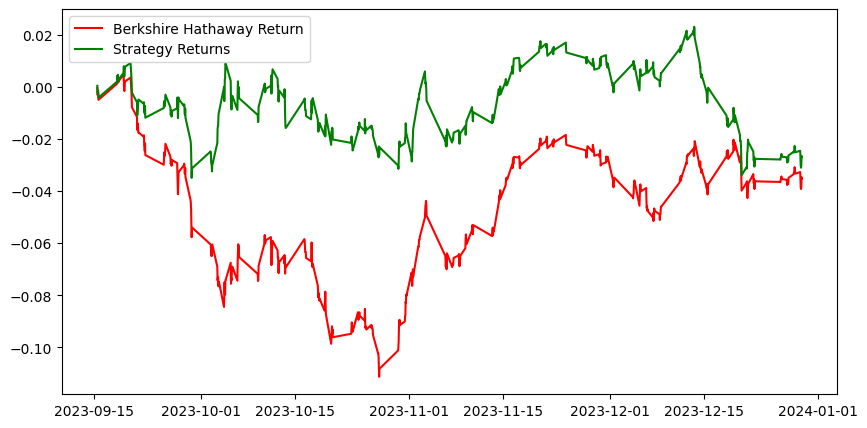

In [ ]:
df['Predicted_Signal'] = model.predict(X)
df['Berkshire_Hathaway_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Berkshire_Hathaway_returns = np.cumsum(df[split:]['Berkshire_Hathaway_returns'])

df['Startegy_returns'] = df['Berkshire_Hathaway_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Berkshire_Hathaway_returns, color='r',label = 'Berkshire Hathaway Return')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

## b. เพิ่ม feature (column) ต่างๆ ที่เราสนใจ จากนั้นให้ทำซ้ำตามข้อ (a.) แล้วแสดงผลลัพธ์ของกราฟเปรียบเทียบกับกราฟในข้อ a.

## Step 1: Import Data
- ต้องการทราบว่า ราคาปิดของหุ้นบริษัท Apple จะส่งต่อผลต่อผลตอบแทนและกระทบหุ้น Berkshire_Hathaway หรือไม่ โดยกำหนดช่วงเวลาเดียวกัน
- เนื่องจากบริษัท Berkshine ลงทุนในหุ้น Apple คิดเป็นมากกว่า 50% ของการลงทุนทั้งหมดของตนเอง

In [ ]:
Apple = yf.Ticker('AAPL')

##ดึงข้อมูลได้แค่ 730 วัน กรณีดึงข้อมูลเป็นรายชั่วโมง

interval = '1h'

start = '2023-1-1'
end = '2023-12-31'

Apple_price_df = Apple.history(interval='1h',start=start,end=end)

df2 = Apple_price_df["Close"]
df2 = pd.DataFrame(df2)
df2

,Close
Datetime,
2023-01-03 09:30:00-05:00,125.459999
2023-01-03 10:30:00-05:00,125.345001
2023-01-03 11:30:00-05:00,124.660004
2023-01-03 12:30:00-05:00,124.649902
2023-01-03 13:30:00-05:00,124.570000
...,...
2023-12-29 11:30:00-05:00,191.899994
2023-12-29 12:30:00-05:00,191.899994
2023-12-29 13:30:00-05:00,192.119995


## Step 2:  Define Predictor/Independent Variables
- เอา df2 ที่เป็นตัวแปรราคาปิดของหุ้นบริษัท Apple (Close_y) ไป merge กับ df1 ที่เป็นข้อมูลหุ้นของ Berkshire_Hathaway โดยยึด row index "Datetime"

In [ ]:
merged_df = pd.merge(df.iloc[:,:9], df2,on='Datetime', how='inner')
merged_df.head()

,Open,High,Low,Close_x,S_10,Corr,RSI,Open-Close,Open-Open,Close_y
Datetime,,,,,,,,,,
2023-01-10 10:30:00-05:00,314.000000,315.959991,313.339996,315.114990,317.266364,-0.094820,49.867408,-0.095001,-1.000000,129.029999
2023-01-10 11:30:00-05:00,315.429993,316.200012,314.651398,315.920013,316.994363,0.149273,53.537603,0.315002,1.429993,129.119995
2023-01-10 12:30:00-05:00,315.924988,316.786987,315.649994,316.056702,316.805032,0.317517,54.170589,0.004974,0.494995,129.659897
2023-01-10 13:30:00-05:00,316.054108,316.799988,315.899994,316.149994,316.412341,0.417340,54.639234,-0.002594,0.129120,130.361206
2023-01-10 14:30:00-05:00,316.075897,316.390015,314.910004,315.581696,315.968512,0.333331,51.102286,-0.074097,0.021790,130.149994


- เปลี่ยนชื่อ column จาก Close_x'เป็น 'Close_BH' แสดงถึงราคาปิดของหุ้น Berkshire
- เปลี่ยนชื่อ column จาก Close_y'เป็น 'Close_APPL' แสดงถึงราคาปิดของหุ้น Apple

In [ ]:
merged_df.rename(columns={'Close_x': 'Close_BH'}, inplace=True)
merged_df.rename(columns={'Close_y': 'Close_APPL'}, inplace=True)

Xb_df = merged_df.iloc[:,:10]

Xb = Xb_df.copy()

Xb.head()

,Open,High,Low,Close_BH,S_10,Corr,RSI,Open-Close,Open-Open,Close_APPL
Datetime,,,,,,,,,,
2023-01-10 10:30:00-05:00,314.000000,315.959991,313.339996,315.114990,317.266364,-0.094820,49.867408,-0.095001,-1.000000,129.029999
2023-01-10 11:30:00-05:00,315.429993,316.200012,314.651398,315.920013,316.994363,0.149273,53.537603,0.315002,1.429993,129.119995
2023-01-10 12:30:00-05:00,315.924988,316.786987,315.649994,316.056702,316.805032,0.317517,54.170589,0.004974,0.494995,129.659897
2023-01-10 13:30:00-05:00,316.054108,316.799988,315.899994,316.149994,316.412341,0.417340,54.639234,-0.002594,0.129120,130.361206
2023-01-10 14:30:00-05:00,316.075897,316.390015,314.910004,315.581696,315.968512,0.333331,51.102286,-0.074097,0.021790,130.149994


## help resolve the convergence warnings, need to scale the data using StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scalerb = StandardScaler()
Xb = scalerb.fit_transform(Xb)  # Assuming X is your feature matrix

##Step 3: Define Target/Dependent Variable
- The dependent variable is the same as discussed in the above example. If tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).

In [ ]:
yb = np.where(merged_df['Close_BH'].shift(-1) > merged_df['Close_BH'],1,-1)
yb

array([ 1,  1,  1, ...,  1, -1, -1])

## Step 4: Split The Dataset
- แบ่งข้อมูลสำหรับ Train 70% และ test  30%

In [ ]:
splitb = int(0.7*len(merged_df))
Xb_train, Xb_test, yb_train, yb_test = Xb[:splitb], Xb[splitb:], yb[:splitb], yb[splitb:]

## Step 5: Logistic Regression

In [ ]:
modelb = LogisticRegression(max_iter=1000)
modelb = modelb.fit(Xb_train,yb_train)

## Step 6: Examine The Coefficients

In [ ]:
pd.DataFrame(zip(Xb_df.columns, np.transpose(modelb.coef_)))

,0,1
0,Open,[0.13073053869928378]
1,High,[-0.5862901609515672]
2,Low,[0.4071200657050755]
3,Close_BH,[0.21354446231066423]
4,S_10,[-0.2740774333770101]
5,Corr,[-0.05024051299072635]
6,RSI,[-0.002980257895870622]
7,Open-Close,[-0.04088212005677815]
8,Open-Open,[-0.10267744473467531]
9,Close_APPL,[0.12157064282675219]


## Step 7: Calculate Class Probabilities
- We will calculate the probabilities of the class for the test dataset using ‘predict_proba’ function.

In [ ]:
# Specify the date for prediction
predictionb_date = '2024-12-22'
probabilityb = modelb.predict_proba(Xb_test)
probabilityb

array([[0.51165996, 0.48834004],
       [0.51349692, 0.48650308],
       [0.47921562, 0.52078438],
       ...,
       [0.44518327, 0.55481673],
       [0.46361395, 0.53638605],
       [0.48363984, 0.51636016]])

## Step 8: Predict Class Labels
- Next, we will predict the class labels using predict function for the test dataset.
- In the output above, the signal shows 1, which is a buy signal
- -1 is a sell signal

In [ ]:
predictedb = modelb.predict(Xb_test)
predictedb

array([-1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1,
       -1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1,
       -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1

## Step 9: Evaluate The Model

## 9.1 Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(yb_test, predictedb))

[[ 74 166]
 [ 71 201]]


## 9.2 Classification Report

In [ ]:
print(metrics.classification_report(yb_test, predictedb))

              precision    recall  f1-score   support

          -1       0.51      0.31      0.38       240
           1       0.55      0.74      0.63       272

    accuracy                           0.54       512
   macro avg       0.53      0.52      0.51       512
weighted avg       0.53      0.54      0.51       512



- The accuracy of the model is at 0.54 or 54%.

## 9.3 Model Accuracy

In [ ]:
print(modelb.score(Xb_test,yb_test))

0.537109375


## 9.4 Cross-Validation

In [ ]:
cross_val = cross_val_score(LogisticRegression(), Xb, yb, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.5497076  0.53216374 0.52631579 0.54385965 0.52046784 0.52046784
 0.51764706 0.55882353 0.48235294 0.51764706]
0.5269453044375645


## Step 8: Create Trading Strategy Using The Model

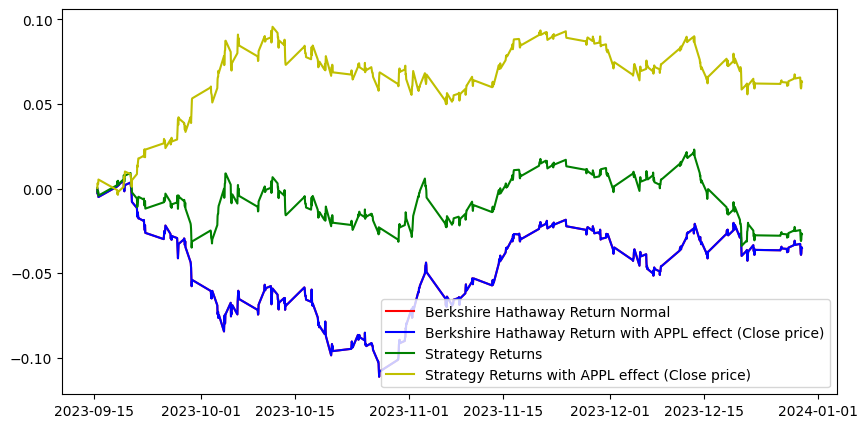

In [ ]:
plt.figure(figsize=(10,5))

##เส้นที่ 1 ผลตอบแทนจริงของ BH กรณีปกติ
plt.plot(Cumulative_Berkshire_Hathaway_returns, color='r',label = 'Berkshire Hathaway Return Normal')


##เส้นที่ 2 ผลตอบแทนจริงของ BH กรณีที่เอาราคาปิดของ Apple มาวิเคราะห์ร่วม/
merged_df['Predicted_Signalb'] = modelb.predict(Xb)
merged_df['BH_APPL'] = np.log(merged_df['Close_BH']/merged_df['Close_BH'].shift(1))
Cumulative_BH_AAPL_returns = np.cumsum(merged_df[splitb:]['BH_APPL'])
plt.plot(Cumulative_BH_AAPL_returns, color='b',label = 'Berkshire Hathaway Return with APPL effect (Close price)')

##เส้นที่ 3 ผลตอบแทนของตาม model กรณีปกติ
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')


##เส้นที่ 4 ผลตอบแทนของตาม model กรณีที่เอาราคาปิดของ Apple มาวิเคราะห์ร่วม
merged_df['Strategy_returnsb'] = merged_df['BH_APPL']* merged_df['Predicted_Signalb'].shift(1)
Cumulative_Strategy_returnsb = np.cumsum(merged_df[splitb:]['Strategy_returnsb'])
plt.plot(Cumulative_Strategy_returnsb, color='y', label = 'Strategy Returns with APPL effect (Close price)')


plt.legend()
plt.show()

- จากกราฟ พบว่า เส้นผลตอบแทนของหุ้น Berkshire กรณีปกติ (Berkshire Hathaway Return Normal) จะใกล้เคียงกับเส้นผลตอบแทนของหุ้น Berkshire กรณีที่นำราคาปิดของหุ้น Apple (APPL) มาวิเคราะห์ร่วมด้วย (Berkshire Hathaway Return with APPL effect (Close price)) อาจเป็นผลมาจากบริษัท Berkshire ได้ลงทุนในหุ้น Apple คิดเป็นมากกว่า 50% ของการลงทุนทั้งหมดของตนเอง ทำให้ไม่แตกต่างกัน
- นอกจากนี้ยังพบว่า logistic Model สามารถพยากรณ์ผลตอบแทนของการลงทุนในหุ้น Berkshire ได้สองรูปแบบคือ
- 1. กราฟเส้นสีเขียว กรณีปกติ ไม่นำผลของราคาปิดของหุ้น Apple (APPL) มาวิเคราะห์ พบว่า Model สามารถพยากรณ์การลงทุนซื้อขาย และสร้างผลตอบแทนได้ดีกว่าผลตอบแทนของหุ้น Berkshire ที่เกิดขึ้นจริง ทุกช่วงเวลาที่นำมาวิเคราะห์ (1-1-2023 ถึง 31-12-2023)
  2. กราฟเส้นสีเหลือง กรณีวิเคราะห์ราคาปิดของหุ้น Apple (APPL)ร่วมด้วย พบว่า Model สามารถพยากรณ์การลงทุนซื้อขาย และสร้างผลตอบแทนได้กว่าผลตอบแทนของหุ้น Berkshire ที่เกิดขึ้นจริงทุกช่วงเวลาที่นำมาวิเคราะห์ (1-1-2023 ถึง 31-12-2023)
- โดยสรุปกรณีที่ 2 (เส้นสีเหลือง) เป็น model ที่สร้างผลตอบแทนได้ดีกว่ากรณีแรก